1. Training features with DT and GradientBoost
2. Feature engineering with DT
3. Feature importance with SHAP and GradientBoost
4. Save variants of models

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import shap
import graphviz
import numpy as np
import scipy
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import pickle

In [3]:
fig_path = '/content/drive/MyDrive/CSC791:NLP/project/figures/'
model_path = '/content/drive/MyDrive/CSC791:NLP/project/models/'

In [4]:
def drop_unnamed_column(df):
  print("before unknown: ", df.shape)
  df = df.drop(columns=df.columns[0])
  print("after dropping unknown: ", df.shape)

  return df

In [5]:
# Drop nulls if any
def drop_nulls(features_df: pd.DataFrame()):
  if features_df.isnull().sum().any() > 0:
    print(f'Dropping Nulls')

  features_df = features_df.dropna()
  print('Features shape after dropping nulls: ',features_df.shape)

  return features_df

In [6]:
def train_dt(data: pd.DataFrame(), fig_name: str(), model_name: str()):
  # Check and drop in any nulls
  data = drop_nulls(data)
  datacopy = data
  feature_names = datacopy.drop('labels', axis=1).columns

  # Train Test Split
  train_data_X, test_data_X, train_data_Y, test_data_Y = train_test_split(data.drop('labels', axis=1), data['labels'], test_size=0.3)
  print(train_data_X.shape, train_data_Y.shape, test_data_X.shape, test_data_Y.shape)

  # Normalize the data
  scaler = StandardScaler()
  scaler.fit(train_data_X)
  print('scaler mean\n',scaler.mean_)
  train_data_X = scaler.transform(train_data_X)
  test_data_X = scaler.transform(test_data_X)
  print(train_data_X.shape, train_data_Y.shape, test_data_X.shape, test_data_Y.shape)

  baseline_model = DecisionTreeClassifier(max_depth=5)
  baseline_model.fit(train_data_X, train_data_Y)
  baseline_model.score(train_data_X, train_data_Y)
  preds = baseline_model.predict(test_data_X)

  fig = plt.figure(figsize=(15,15))

  print(classification_report(preds, test_data_Y))

  tree.plot_tree(baseline_model, feature_names=feature_names, class_names=['True', 'False'], filled=True, fontsize=10)
  plt.show()

  fig.savefig(fig_path + fig_name)
  print('Figure saved')

  # save the iris classification model as a pickle file
  model_pkl_file = model_path + model_name

  with open(model_pkl_file, 'wb') as file:
    pickle.dump(baseline_model, file)

  print('Model saved')

  return baseline_model

In [7]:
def train_gbc_with_shap(data: pd.DataFrame(), model_name: str()):
  # Check and drop in any nulls
  data = drop_nulls(data)
  datacopy = data
  feature_names = datacopy.drop('labels', axis=1).columns
  print(feature_names)

  # Train Test Split
  train_data_X, test_data_X, train_data_Y, test_data_Y = train_test_split(data.drop('labels', axis=1), data['labels'], test_size=0.3)
  print(train_data_X.shape, train_data_Y.shape, test_data_X.shape, test_data_Y.shape)

  model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=3)
  model.fit(train_data_X, train_data_Y)

  preds = model.predict(test_data_X)
  print(classification_report(preds, test_data_Y))

  # # SHAP Explainer
  explainer = shap.Explainer(model.predict, test_data_X)
  shap_values = explainer(test_data_X)

  shap.summary_plot(shap_values, max_display=5, show=False, plot_type='bar')

  # save the iris classification model as a pickle file
  model_pkl_file = model_path + model_name

  with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

  print('Model saved')

  return model, shap_values

### Read dataset

In [8]:
dataset = pd.read_csv(r"/content/drive/MyDrive/CSC791:NLP/project/dataset.csv")
# Separate the X(jokes) and the Y(is_humor or not)

jokes = list(dataset['text'])
labels = list(dataset['humor'])

### Read three feature dataframes

In [9]:
nrc_lex_features = pd.read_csv('/content/drive/MyDrive/CSC791:NLP/project/nrclex-features.csv')
syntactic_features = pd.read_csv('/content/drive/MyDrive/CSC791:NLP/project/syntactic-features.csv')
semantic_features = pd.read_csv('/content/drive/MyDrive/CSC791:NLP/project/semantic_features.csv')

In [10]:
nrc_lex_features.shape, syntactic_features.shape, semantic_features.shape

((200000, 11), (200000, 15), (200000, 10))

In [11]:
nrc_lex_features = drop_unnamed_column(nrc_lex_features)
syntactic_features = drop_unnamed_column(syntactic_features)
semantic_features = drop_unnamed_column(semantic_features)

before unknown:  (200000, 11)
after dropping unknown:  (200000, 10)
before unknown:  (200000, 15)
after dropping unknown:  (200000, 14)
before unknown:  (200000, 10)
after dropping unknown:  (200000, 9)


In [12]:
# Combine all features
features = pd.concat([nrc_lex_features, syntactic_features, semantic_features], axis=1)
features.shape

(200000, 33)

In [13]:
features.to_csv('/content/drive/MyDrive/CSC791:NLP/project/combined-features.csv')

In [14]:
# Concat Labels in feature dataframes
nrc_lex_features['labels'] = labels
syntactic_features['labels'] = labels
semantic_features['labels'] = labels
features['labels'] = labels

nrc_lex_features.shape, syntactic_features.shape, semantic_features.shape, features.shape

((200000, 11), (200000, 15), (200000, 10), (200000, 34))

Features shape after dropping nulls:  (200000, 11)
(140000, 10) (140000,) (60000, 10) (60000,)
scaler mean
 [0.009693   0.00615062 0.01046175 0.015207   0.00710163 0.02832822
 0.02115827 0.00700893 0.0043866  0.00751067]
(140000, 10) (140000,) (60000, 10) (60000,)
              precision    recall  f1-score   support

       False       0.48      0.65      0.56     22233
        True       0.74      0.59      0.66     37767

    accuracy                           0.61     60000
   macro avg       0.61      0.62      0.61     60000
weighted avg       0.65      0.61      0.62     60000



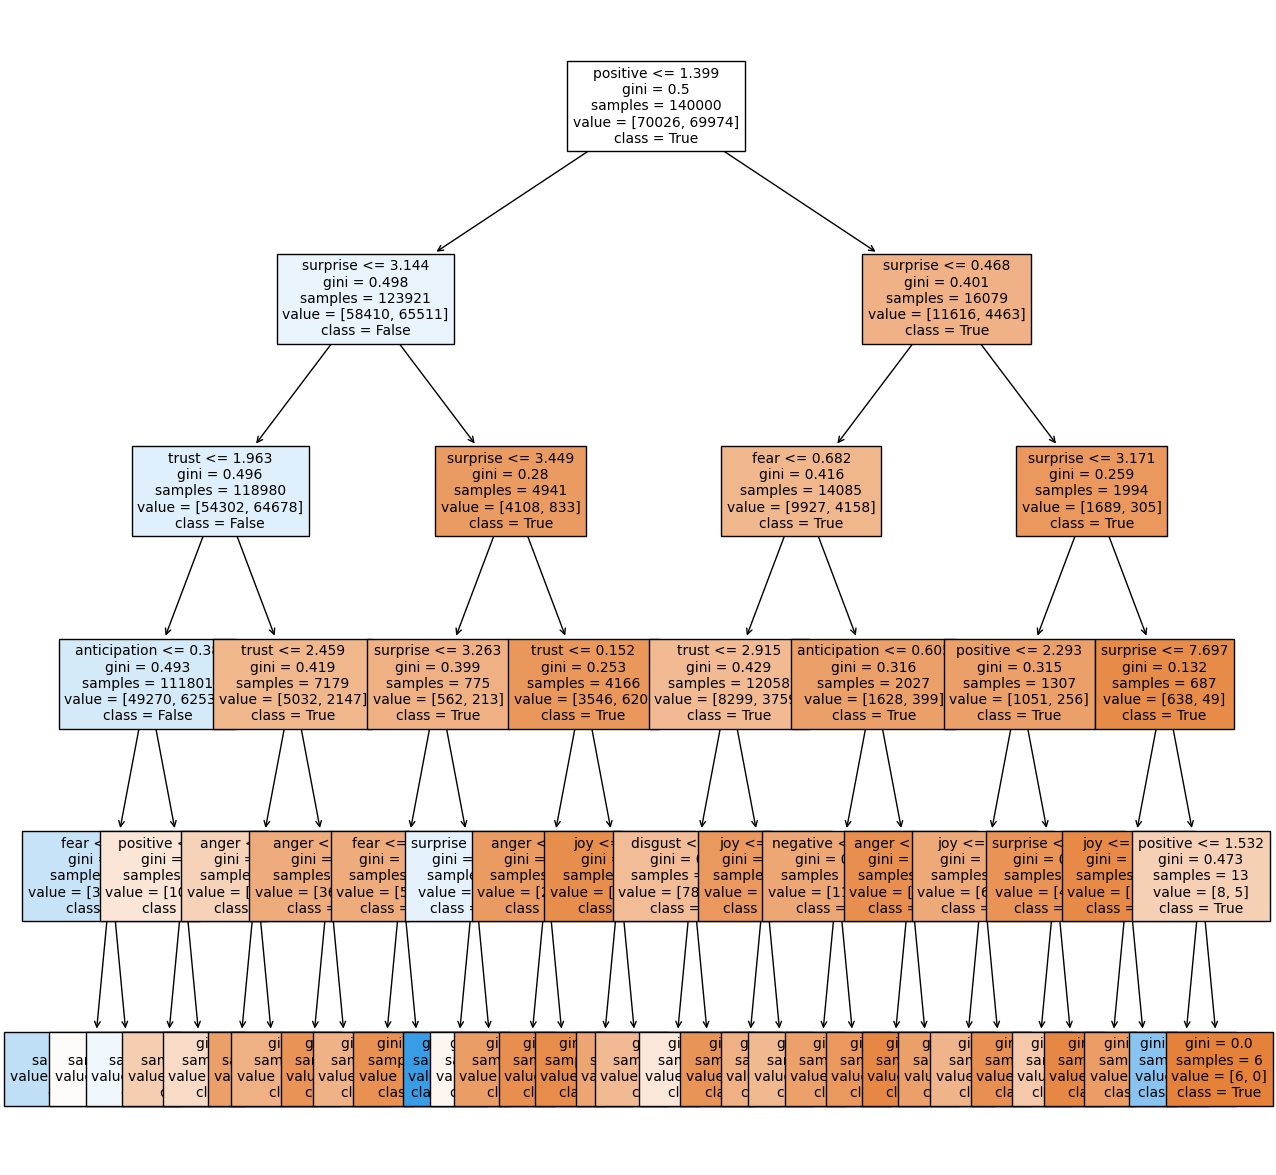

Figure saved
Model saved


In [15]:
nrclex_model = train_dt(nrc_lex_features, 'dt_nrclex.png', 'dt_nrclex.pkl')

Features shape after dropping nulls:  (200000, 15)
(140000, 14) (140000,) (60000, 14) (60000,)
scaler mean
 [3.23007857 2.31770714 0.78235    0.00812857 0.51973531 0.36419973
 0.11491571 0.35856455 0.50650807 0.18665232 2.37573463 1.69586856
 0.74013154 0.3258376 ]
(140000, 14) (140000,) (60000, 14) (60000,)
              precision    recall  f1-score   support

       False       0.69      0.74      0.72     28101
        True       0.76      0.71      0.73     31899

    accuracy                           0.73     60000
   macro avg       0.73      0.73      0.73     60000
weighted avg       0.73      0.73      0.73     60000



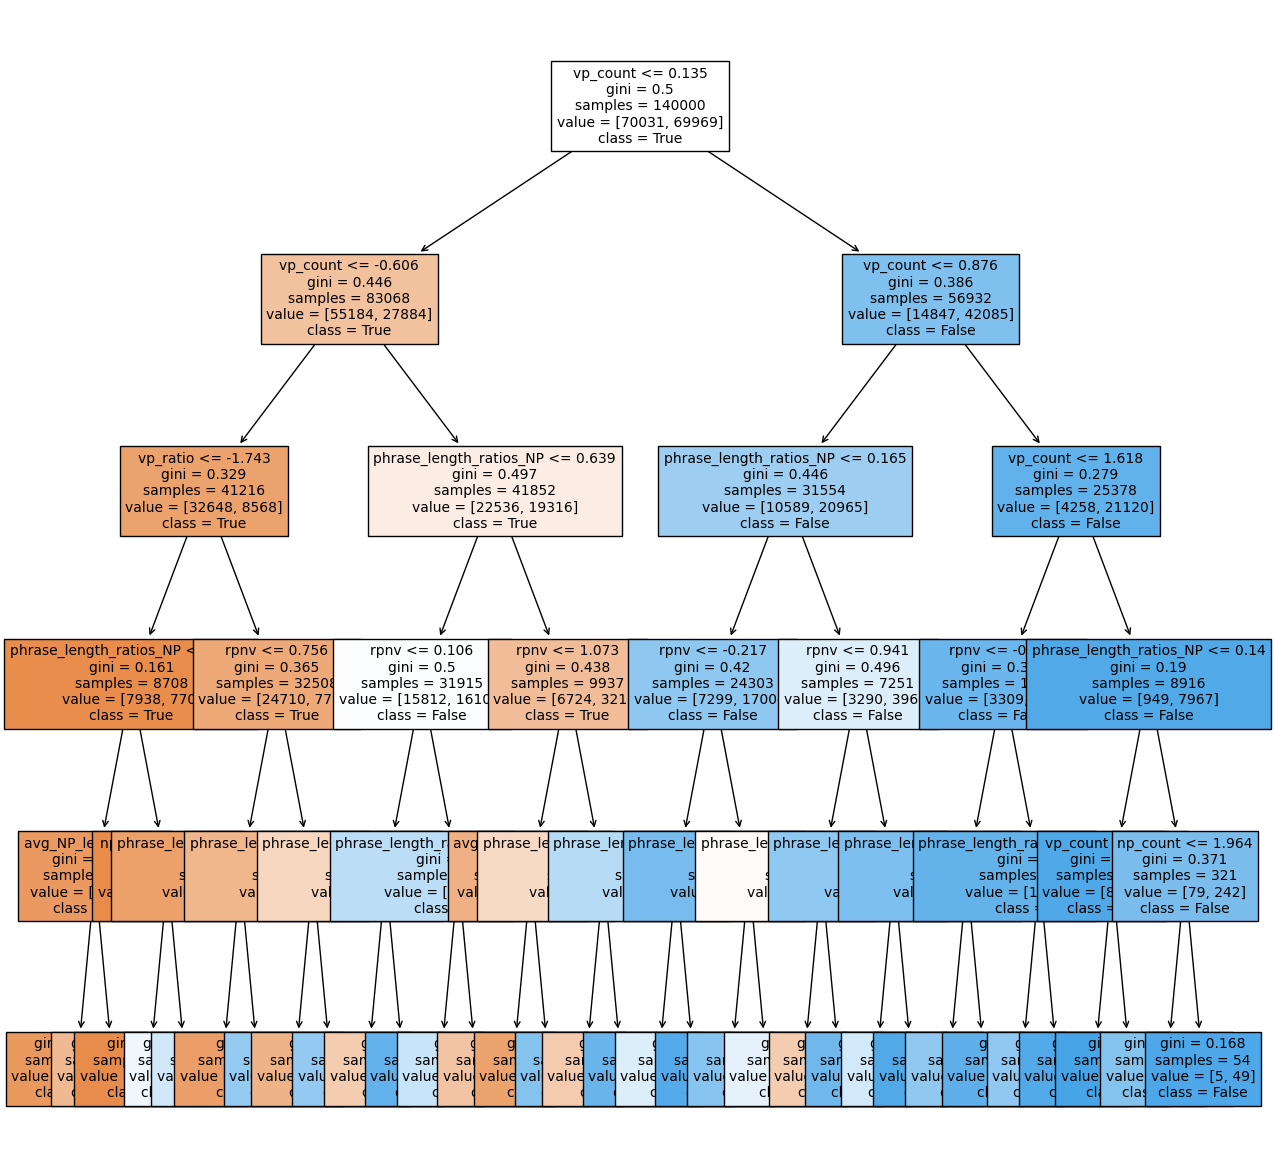

Figure saved
Model saved


In [16]:
syntactic_model = train_dt(syntactic_features, 'dt_syntactic.png', 'dt_syntactic.pkl')

Dropping Nulls
Features shape after dropping nulls:  (199974, 10)
(139981, 9) (139981,) (59993, 9) (59993,)
scaler mean
 [ 8.99178185e-01 -2.10253153e-01  7.54223582e+08  4.38380387e-01
  5.21619485e-02  7.55446096e+00  2.00740815e+00  7.01257313e+00
  2.26830784e+00]
(139981, 9) (139981,) (59993, 9) (59993,)
              precision    recall  f1-score   support

       False       0.70      0.66      0.68     31991
        True       0.64      0.68      0.66     28002

    accuracy                           0.67     59993
   macro avg       0.67      0.67      0.67     59993
weighted avg       0.67      0.67      0.67     59993



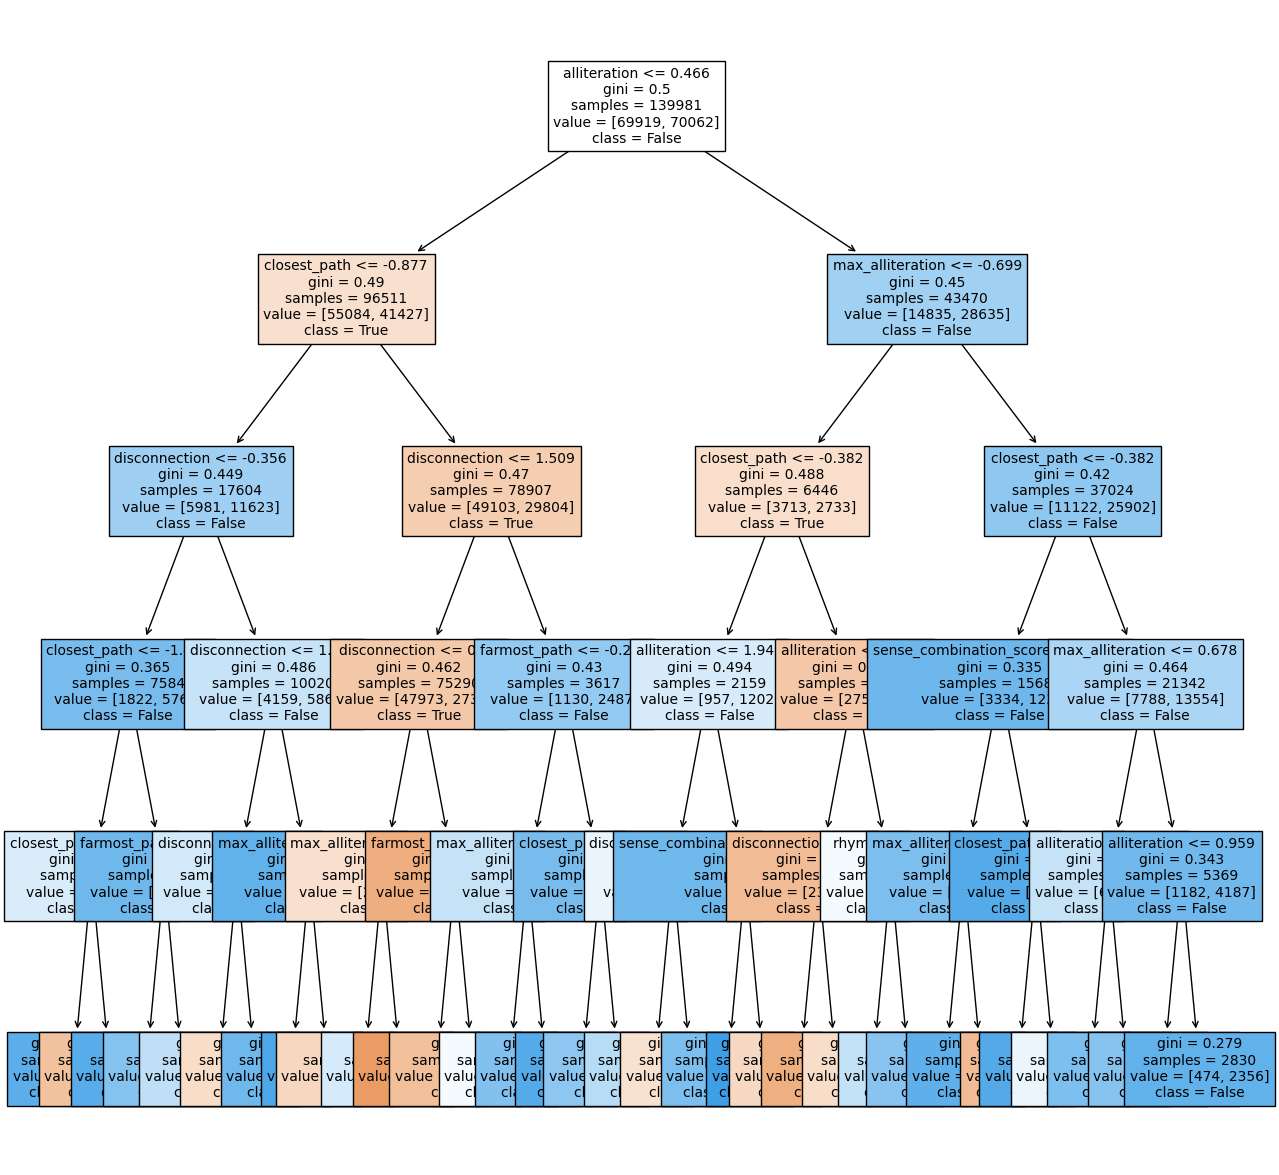

Figure saved
Model saved


In [17]:
semantic_model = train_dt(semantic_features, 'dt_semantic.png', 'dt_semantic.pkl')

Dropping Nulls
Features shape after dropping nulls:  (199974, 34)
(139981, 33) (139981,) (59993, 33) (59993,)
scaler mean
 [ 9.74686064e-03  6.22837379e-03  1.04638635e-02  1.53520505e-02
  7.06169015e-03  2.82821663e-02  2.10868611e-02  7.04535216e-03
  4.42178807e-03  7.57990695e-03  3.23115994e+00  2.31907187e+00
  7.81756095e-01  8.16539387e-03  5.19724048e-01  3.64343342e-01
  1.14769494e-01  3.59045473e-01  5.06370970e-01  1.86541917e-01
  2.37563985e+00  1.69521758e+00  7.39247393e-01  3.26763658e-01
  8.99292563e-01 -2.09998714e-01  2.92328960e+08  4.38548843e-01
  5.21743399e-02  7.55812575e+00  2.00790107e+00  7.01430194e+00
  2.27098678e+00]
(139981, 33) (139981,) (59993, 33) (59993,)
              precision    recall  f1-score   support

       False       0.74      0.73      0.74     30230
        True       0.73      0.74      0.73     29763

    accuracy                           0.74     59993
   macro avg       0.74      0.74      0.74     59993
weighted avg       0.74

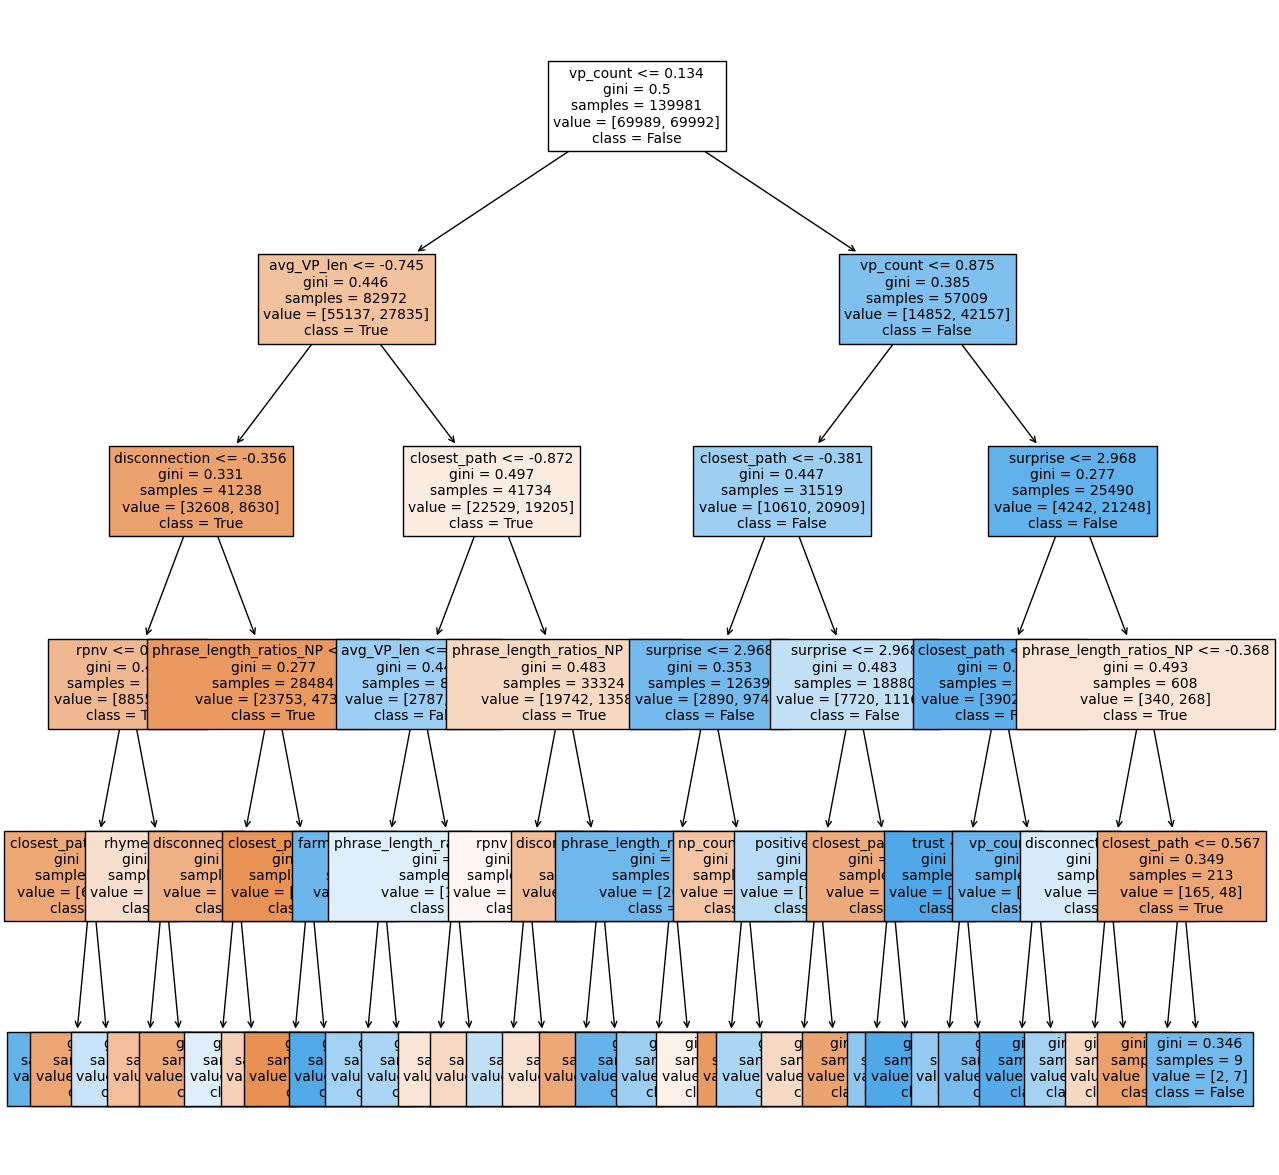

Figure saved
Model saved


In [18]:
combined_model = train_dt(features, 'dt_combined_features.png', 'dt_combined_features.pkl')

Features shape after dropping nulls:  (200000, 11)
Index(['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive',
       'negative', 'sadness', 'disgust', 'joy'],
      dtype='object')
(140000, 10) (140000,) (60000, 10) (60000,)
              precision    recall  f1-score   support

       False       0.38      0.70      0.49     16353
        True       0.83      0.57      0.68     43647

    accuracy                           0.61     60000
   macro avg       0.61      0.63      0.59     60000
weighted avg       0.71      0.61      0.63     60000



ExactExplainer explainer: 60001it [22:54, 43.47it/s]                           


Model saved


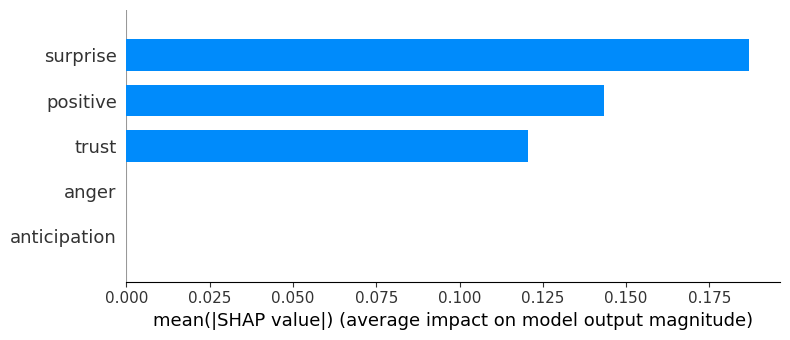

In [19]:
nrclex_model_gbc, lex_shap_values = train_gbc_with_shap(nrc_lex_features, 'gbc_nrclex.pkl')

Features shape after dropping nulls:  (200000, 15)
Index(['np_count', 'vp_count', 'pp_count', 'sbar_count', 'np_ratio',
       'vp_ratio', 'pp_ratio', 'phrase_length_ratios_VP',
       'phrase_length_ratios_NP', 'phrase_length_ratios_PP', 'avg_NP_len',
       'avg_VP_len', 'avg_PP_len', 'rpnv'],
      dtype='object')
(140000, 14) (140000,) (60000, 14) (60000,)
              precision    recall  f1-score   support

       False       0.73      0.70      0.72     31437
        True       0.69      0.72      0.70     28563

    accuracy                           0.71     60000
   macro avg       0.71      0.71      0.71     60000
weighted avg       0.71      0.71      0.71     60000



PermutationExplainer explainer: 60001it [1:02:57, 15.84it/s]


Model saved


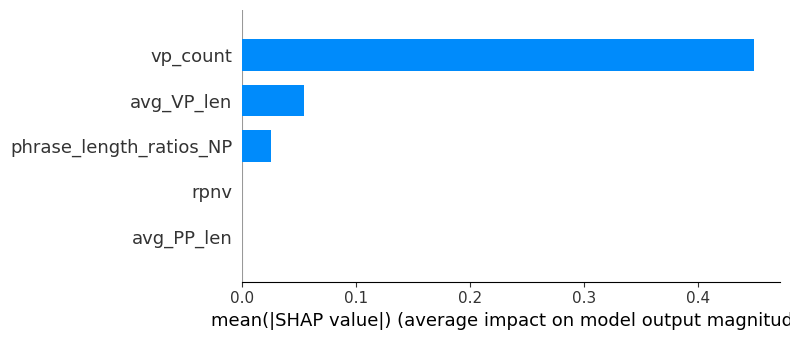

In [20]:
syntactic_model_gbc, syntactic_shap_values = train_gbc_with_shap(syntactic_features, 'gbc_syntactic.pkl')

Dropping Nulls
Features shape after dropping nulls:  (199974, 10)
Index(['disconnection', 'repetition', 'sense_combination_score',
       'farmost_path', 'closest_path', 'alliteration', 'max_alliteration',
       'rhyme', 'max_rhyme'],
      dtype='object')
(139981, 9) (139981,) (59993, 9) (59993,)
              precision    recall  f1-score   support

       False       0.71      0.64      0.67     33450
        True       0.60      0.67      0.63     26543

    accuracy                           0.65     59993
   macro avg       0.65      0.65      0.65     59993
weighted avg       0.66      0.65      0.65     59993



ExactExplainer explainer: 59994it [17:38, 56.04it/s]


Model saved


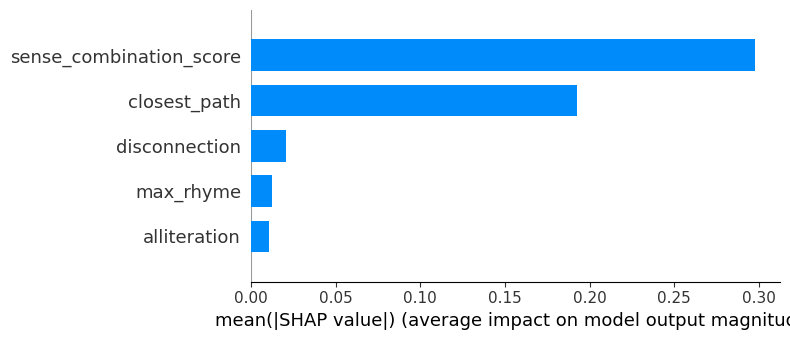

In [21]:
semantic_model_gbc, semantic_shap_values = train_gbc_with_shap(semantic_features, 'gbc_semantic.pkl')

Dropping Nulls
Features shape after dropping nulls:  (199974, 34)
Index(['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive',
       'negative', 'sadness', 'disgust', 'joy', 'np_count', 'vp_count',
       'pp_count', 'sbar_count', 'np_ratio', 'vp_ratio', 'pp_ratio',
       'phrase_length_ratios_VP', 'phrase_length_ratios_NP',
       'phrase_length_ratios_PP', 'avg_NP_len', 'avg_VP_len', 'avg_PP_len',
       'rpnv', 'disconnection', 'repetition', 'sense_combination_score',
       'farmost_path', 'closest_path', 'alliteration', 'max_alliteration',
       'rhyme', 'max_rhyme'],
      dtype='object')
(139981, 33) (139981,) (59993, 33) (59993,)
              precision    recall  f1-score   support

       False       0.76      0.70      0.73     32445
        True       0.68      0.74      0.71     27548

    accuracy                           0.72     59993
   macro avg       0.72      0.72      0.72     59993
weighted avg       0.72      0.72      0.72     59993



PermutationExplainer explainer: 59994it [45:20, 21.96it/s]                           


Model saved


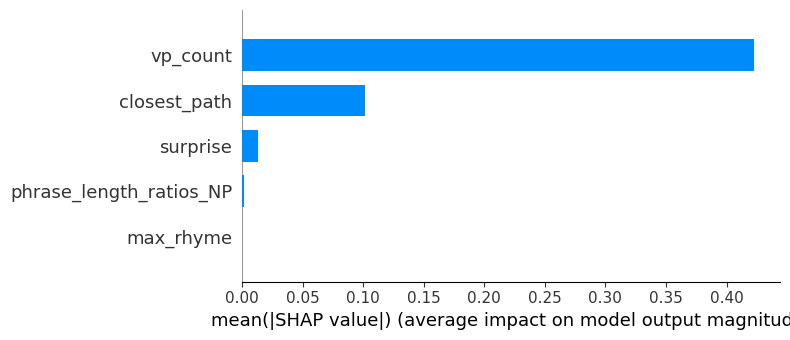

In [22]:
combined_model_gbc, com_shap_values = train_gbc_with_shap(features, 'gbc_combined_features.pkl')